In [ ]:
#data=pd.read_csv(r"E:\jupyter notebook program\matrix_Friendship.csv",header=None)
#data=pd.read_csv(r"E:\jupyter notebook program\matrix_celegans_n306.csv",header=None)
#data=pd.read_csv(r"E:\jupyter notebook program\matrix_convote.csv",header=None)
#data=pd.read_csv(r"E:\jupyter notebook program\matrix_moreno_innovation.csv",header=None)
#data=pd.read_csv(r"E:\jupyter notebook program\matrix_foodweb.csv",header=None)
#data=pd.read_csv(r"E:\jupyter notebook program\matrix_wiki_talk.csv",header=None)


#data=pd.read_csv(r"D:\看论文\14.小型LFR\LFR-1\matrix_data500边.csv",header=None)
#data=pd.read_csv(r"D:\看论文\14.小型LFR\LFR-2\matrix_data500边.csv",header=None)
#data=pd.read_csv(r"D:\看论文\14.小型LFR\LFR-3\matrix_data500边.csv",header=None)
#data=pd.read_csv(r"D:\看论文\14.小型LFR\LFR-4\matrix_data500边.csv",header=None)
#data=pd.read_csv(r"D:\看论文\14.小型LFR\LFR-5\matrix_data500边.csv",header=None)
#data=pd.read_csv(r"D:\看论文\14.小型LFR\LFR-6\matrix_data500边.csv",header=None)
#data=pd.read_csv(r"D:\看论文\14.小型LFR\LFR-7\matrix_data500边.csv",header=None)
data=pd.read_csv(r"D:\1.看论文0\14.小型LFR\LFR-8\matrix_data500边.csv",header=None)

	
	
	
模块度最大为： 0.5320763133417478
阈值： 0.19191919191919204
社区数量： 7
用时： 0.3080317974090576


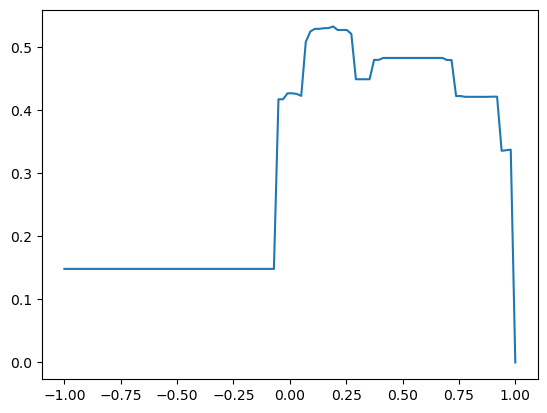

In [2]:
#LLE
import pandas as pd

#data=pd.read_csv(r"E:\jupyter notebook program\matrix_Friendship.csv",header=None)
#data=pd.read_csv(r"E:\jupyter notebook program\matrix_celegans_n306.csv",header=None)
#data=pd.read_csv(r"E:\jupyter notebook program\matrix_convote.csv",header=None)
#data=pd.read_csv(r"E:\jupyter notebook program\matrix_moreno_innovation.csv",header=None)
#data=pd.read_csv(r"E:\jupyter notebook program\matrix_foodweb.csv",header=None)
data=pd.read_csv(r"E:\jupyter notebook program\matrix_wiki_talk.csv",header=None)
num_nodes=data.shape[0]


import numpy as np
F=[]
F.append(np.sum(data,axis=0))


P=np.zeros((num_nodes,num_nodes))
for i in range(num_nodes):
    for j in range(num_nodes):
        if F[0][j]==0:
            F[0][j]=0.001
        P[j][i]=(data[j][i]/F[0][j])*1
        if P[j][i]==0:
            P[j][i]=0.001

            
D=np.zeros((num_nodes,num_nodes))
import math 
for i in range(num_nodes):
    for j in range(num_nodes):
        D[i][j]=1-math.log(P[i][j],10)
        if i==j:
            D[i][j]=10


#邻居节点数量的选择
n_neighbors=50
N=np.zeros((num_nodes,n_neighbors))
for i in range(num_nodes):
    index_=np.argsort(D[i])[0:n_neighbors]
    N[i]=N[i]+index_
N=N.astype(np.int32)
#print(N)  #astype() 对数据类型进行转换


Xi = np.tile(data[i], (n_neighbors, 1)).T
Xi=pd.DataFrame(Xi)
Ni = data[N[i]].T
Si = np.dot((Xi-Ni).T, (Xi-Ni))


from scipy import linalg
def lle(data, n_dims=100, n_neighbors=50):
    #N = get_n_neighbors(data, n_neighbors)            # k近邻索引
    #n, D = data.shape                                 # n_samples, n_features
    # prevent Si to small
    if n_neighbors > num_nodes:
        tol = 1e-3
    else:
        tol = 0
    # calculate W
    W = np.zeros((n_neighbors, num_nodes))
    I = np.ones((n_neighbors, 1))
    for i in range(num_nodes):                                # data[i] => [1, n_features]
        Xi = np.tile(data[i], (n_neighbors, 1)).T     # [n_features, n_neighbors]
        Xi=pd.DataFrame(Xi)                           # N[i] => [1, n_neighbors]
        Ni = data[N[i]].T                             # [n_features, n_neighbors]
        Si = np.dot((Xi-Ni).T, (Xi-Ni))               # [n_neighbors, n_neighbors]
        #Si = Si + np.eye(n_neighbors)*tol*np.trace(Si)
        Si_inv = linalg.pinv(Si)
        wi = (np.dot(Si_inv, I)) / (np.dot(np.dot(I.T, Si_inv), I)[0,0])
        W[:, i] = wi[:,0]
    W_y = np.zeros((num_nodes, num_nodes))
    for i in range(num_nodes):
        index = N[i]
        for j in range(n_neighbors):
            W_y[index[j],i] = W[j,i]
    I_y = np.eye(num_nodes)
    M = np.dot((I_y - W_y), (I_y - W_y).T)
    eig_val, eig_vector = np.linalg.eig(M)
    index_ = np.argsort(np.abs(eig_val))[1:n_dims+1]
    Y = eig_vector[:, index_]
    return Y
out_data = np.nan_to_num(data)
lle=lle(out_data,n_dims=100,n_neighbors=50)
ne=lle
#print(lle)


import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import spatial


#计算模块度的函数
def Modularity(array,cluster):  #有向网络的模块度
    #总边数
    m = np.sum(array) #对整个01矩阵求和，是有向网络中的总边数
    k1 = np.sum(array,axis=1) #axis指第二个维度，对第二个维度进行求和   求行和，每个节点的出度，返回一维数组
    k2 = np.sum(array,axis=0) #axis指第一个维度，对第一个维度进行求和   求列和，每个节点的入度，返回一维数组
    k2 = k2.reshape(k2.shape[0],1)
    #节点度数的乘积
    k1k2 = (k1*k2).T
    #任意两点连接边数的期望值
    Eij = k1k2/m
    #节点v和w的实际边数与随机网络下边数期望之差
    B = array - Eij
    #获取节点、社区矩阵
    node_cluster = np.dot(cluster,np.transpose(cluster))  #将cluster矩阵转置
    results = np.dot(B,node_cluster)
    #求和
    sum_results = np.trace(results) #这里求迹是因为上一步原矩阵与社区矩阵相乘之后，所求的即迹
    #模块度计算
    Q = sum_results / m
    return Q

#获得社区矩阵的函数，就是将pi中的社区划分改为矩阵形式，矩阵的行为点的数量，列为社区的数量      点的数量×社区的数量
def Get_cluster(G,pi):
    cluster=np.zeros((len(G),len(pi)),dtype='int32') # 'int32'数组中的每个元素是32位的整数
    #len(G)图中节点的数量，即图的大小
    #cluster是节点数×社区数的全整数0矩阵*
    s=0
    for i in pi:           #每个社区                              
        #j为点的标号
        for j in list(i):                     
            #将同一个社区的点对应位置赋值为1
            cluster[j][s]=1
        #一个社区赋值完成，进行下一个社区，直到全部赋值完成
        s=s+1
    return cluster

#计算D矩阵的函数
def calculateD(G_array,pi):
    matrixD=np.zeros((len(pi),len(pi)))   #社区的个数×社区的个数
    #遍历每两个不同社区，将所有的边数求和
    li1=[]
    s=0
    #这样取循环是为了保证两个社区是不同的
    for i in pi[s:]:
        for j in pi[s+1:]:
            if len(j)==0: #社区内没有节点
                break
            else:
                #对社区间的边数求和  使用有向网络邻接矩阵改成的无向网络的邻接矩阵 计算社区之间的边数       出度和入度的权重                                        
                li1.append(np.sum(G_array[list(i),:][:,list(j)])/(len(i)+len(j)))
                #出的边和入的边算两遍
                #li1.append((np.sum(G_array[list(i),:][:,list(j)])+np.sum(G_array[list(j),:][:,list(i)]))/(len(i)+len(j)))
                #D=calculateD(G_array,pi1)
        s=s+1
        
    v=0
    for a in range(matrixD.shape[0]):
        for b in range(matrixD.shape[1]):
            if b>a:
                matrixD[a][b]=li1[v]
                #matrixD[b][a] = matrixD[a][b]
                v=v+1
    matrixD += matrixD.T
    #这里相当于改进，没有计算相同社区的
    '''
    #遍历相同的社区，将所有的边数求和
    b=0
    for x in pi:
          c=np.sum(G_array[list(x),:][:,list(x)])
          matrixD[b][b]=c
          b=b+1   
    '''
    #print("D矩阵为：",matrixD)
    return matrixD

#定位并合并两个社区，更新原列表pi
def Index_and_merge_communities(D,pi):                                               #×  看不懂
    #把D转换为一维的列表
    Dlist=D.reshape(1,D.size).tolist()[0]    #size返回数组中的元素总数 tolist将数组转换为python列表 
    M=Dlist.index(max(Dlist))  #这里也是不同的原因之一  #返回第一次出现max(Dlist)的索引
    s=divmod(M,len(pi))  #求M与len(pi)的商和余数，商和余数各代表一个社区
    jihe=pi[s[0]]|pi[s[1]]  #联合操作                                             #×
    if s[0]>s[1]: 
        del pi[s[0]]    #删除
        del pi[s[1]]
    elif s[0]==s[1]:
        del pi[s[0]]
    elif s[0]<s[1]:
        del pi[s[1]]
        del pi[s[0]]
    pi.append(jihe)
    return pi



x=[]
y=[]
z=[]
w=[]
for yu in np.linspace(-1,1,100):
    
    #计算程序运行时间
    import time
    start=time.time()

    Theta=yu
    #s=np.array(pd.read_csv(r"D:\数据及程序\dolphin1.csv"))  #阈值取110
    # 加载网络数据
    s=np.array(data)
    #生成一个无向图
    G=nx.DiGraph(s)  #原图
    #将读入的0-1矩阵赋值给G_array
    G_array=s
    g=nx.DiGraph(s)
    pi=[]   #社区
    Cr=[]   #单独的点



    #STEP1
    #取有连边的两个点
    for i in list(g.edges.data()):
        a=i[0]
        b=i[1]
        #用嵌入向量计算余弦相似度
        #scipy 模块中的spatial.distance.cosine() 函数可以用来计算余弦相似性，但是必须要用1减去函数值得到的才是余弦相似度
        Sab = 1 - spatial.distance.cosine(ne[a],ne[b])
        #将计算得到的节点相似度赋权给每一条边
        g.add_weighted_edges_from([(a,b,Sab)])
        #根据设置的阈值Theta，节点相似度小于阈值的则进行删边
        if Sab>Theta:
            pass    #空语句，什么也不做
        else:
            g.remove_edge(a,b)



    #找到网络中的连通分支，并将其添加到不同的列表    # nx.strongly_connected_components(G)   获取有向图的连通分量 
    for j in list(nx.strongly_connected_components(g)):  #获取无向图的连通分量     #是否应该改为获取无向图的连通分量
        if len(j)>1:
            pi.append(j)
        else:
            Cr.append(j)

    s_nondi=s        
    for i in range(len(s_nondi[0])):
        for j in range(len(s_nondi[0])):
            if s_nondi[i][j]==1:
                s_nondi[j][i]=1        
    G_nondi=nx.DiGraph(s_nondi)#社团之间有边就行，有向图要看方向，但不管什么方向，都是一个连接        

    #将Cr里面的单个点与pi中的连通分支做计算求得最大的F值，进行定位后，划分到pi中的社区
    #这里的定位是一个易错点
    #判断是否需要进行合并操作       
    if len(Cr)>0 and len(pi)>0:
        #遍历Cr中的单个点
        for i in Cr:
            #存储计算的Fc值的列表，并利用其进行定位
            elist=[]
            #遍历pi中的小社区
            for j in pi:   
                #计算每个点与小社区的Fc值
                Fc=(len(set(G_nondi.adj[list(i)[0]])&j))/len(j)   #G.adj获取邻接字典               
                elist.append(Fc)
            #找最大值可能是造成不同的原因，当同时有多个最大值时，python中提取的是第一个
            #利用列表的定位函数，将该点与有最大F值的社区合并
            M=elist.index(max(elist))  
            pi[M].add(list(i)[0])        




    pi1=pi.copy()      #pi1获取到pi的值
    Q2=0
    Q=Modularity(G_array, Get_cluster(G, pi))
    #当剩余社区数量大于2时，继续该循环
    while len(pi1)>2:
        #计算D矩阵
        D=calculateD(s_nondi,pi1)
        #合并指定的两个社区
        pi1=Index_and_merge_communities(D,pi1)
        #计算当前社区划分的模块度
        Q1=Modularity(G_array, Get_cluster(G, pi1))
        if Q1==Q2:    #模块度不变，取此次社区划分
            break
        if Q1>Q:     #模块度变大
            pi=pi1.copy()
            Q=Q1.copy()
        #当本次社区划分的模块度小于上一次时，结束本循环
        else:
            break
    
        Q2=Q1.copy()
    


    
    #print("社区划分为：",pi)
    #print("类型：",type(pi))
    '''
    print("社区数量为：",len(pi))
    #模块度在0.3-0.7之间就可以称之为划分的很好
    #模块度的取值范围是[-0.5,1)
    print("模块度Q为：",Q)
    print("阈值为：",Theta)
    '''
    end=time.time()
    t=end-start
    #print("用时{:.10f}秒".format(t))    
    x.append(Theta)
    y.append(Q)
    z.append(len(pi))
    w.append(t)
plt.plot(x,y)
print('\t')
print('\t')
print('\t')
print("模块度最大为：",max(y))
print("阈值：",x[y.index(max(y))])
print("社区数量：",z[y.index(max(y))])
print("用时：",w[y.index(max(y))])

节点个数： 536


100%|██████████████████████████████████████████████████████████████████████████████| 536/536 [00:00<00:00, 4432.98it/s]


26800


E:\Ana\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


	
	
	
模块度最大为： 0.42564613473036583
阈值： 0.1282051282051282
社区数量： 6
用时： 0.30741405487060547
社区划分： [{512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 530, 531, 532, 533, 534, 535, 25, 26, 36, 37, 38, 40, 67, 82, 99, 102, 105, 106, 108, 112, 122, 123, 125, 129, 131, 132, 133, 172, 205, 206, 224, 225, 227, 230, 237, 240, 242, 243, 245, 246, 247, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 260, 261, 262, 263, 265, 266, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 297, 302, 303, 304, 306, 307, 309, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 346, 347, 348, 349, 350, 351, 353, 354, 355, 356, 357, 358, 359, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 377, 378, 379, 380, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 39

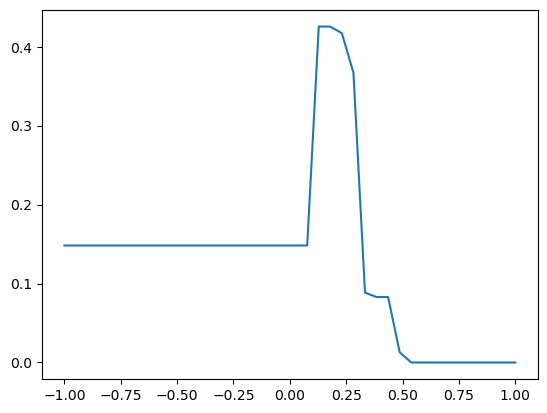

In [3]:
#DeepWalk 
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import networkx as nx

G = nx.DiGraph()

#matrix=pd.read_csv(r"E:\jupyter notebook program\matrix_Friendship.csv",header=None)
#matrix=pd.read_csv(r"E:\jupyter notebook program\matrix_celegans_n306.csv",header=None)
#matrix=pd.read_csv(r"E:\jupyter notebook program\matrix_convote.csv",header=None)
#matrix=pd.read_csv(r"E:\jupyter notebook program\matrix_moreno_innovation.csv",header=None)
#matrix=pd.read_csv(r"E:\jupyter notebook program\matrix_foodweb.csv",header=None)
matrix=pd.read_csv(r"E:\jupyter notebook program\matrix_wiki_talk.csv",header=None)

G=nx.DiGraph(matrix)
print('节点个数：',len(G))
#生成随机游走节点序列的函数
def get_random_walk(node, path_length):
    #:param node: 节点
    #:param path_length: 最大游走长度 
    #:return: 生成随机游走序列

    random_walk = [node]
    
    for i in range(path_length-1):
        #汇总邻接节点
        temp = list(G.neighbors(node))
        temp = list(set(temp)- set(random_walk))
        if len(temp) == 0:
            break
        random_node = random.choice(temp)
        random_walk.append(random_node)
        node = random_node

    return random_walk
all_nodes = list(G.nodes())
#print(all_nodes)
walk_0 = get_random_walk(2, 5)
#print(walk_0)
#生成多个随机游走序列
gamma = 50
walk_length = 2

random_walks = []
for n in tqdm(all_nodes) :
    for i in range(gamma):
        random_walks.append(get_random_walk(n, walk_length))

#查看生成的随机游走的序列个数
print(len(random_walks))
#29970
#print(random_walks[1])


from gensim.models import Word2Vec  #引入自然语言处理中的word2Vec
model = Word2Vec(vector_size=10,
                 window=4,
                 sg=1,#skip_gram
                 hs=0, #不加分层softmax
                 negative=10, #负采样
                 alpha=0.03, #初始学习率
                 min_alpha=0.0007, #最小学习率
                 seed=14) #随机数种子
#用随机游走序列构建词汇表
model.build_vocab(random_walks, progress_per=2)
#训练
model.train(random_walks, total_examples=model.corpus_count, epochs=50, report_delay=1)
#查看某个节点的Embedding
#print(model.wv.get_vector(1).shape)

#print(model.wv.get_vector(1))

#找相似的词语
a = model.wv.similar_by_word(1)
#print(a)
"""
for i in all_nodes:
    print(model.wv.get_vector(i))
"""
DeepWalk=[]                               # 创建一个空列表 a
for i in all_nodes:     # 遍历嵌入向量字典的值
    DeepWalk.append(model.wv.get_vector(i)) # 将嵌入向量添加到列表 a 中
#a                                  # 打印列表 a
#print(DeepWalk)
ne=DeepWalk

import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import spatial


#计算模块度的函数
def Modularity(array,cluster):  #有向网络的模块度
    #总边数
    m = np.sum(array) #对整个01矩阵求和，是有向网络中的总边数
    k1 = np.sum(array,axis=1) #axis指第二个维度，对第二个维度进行求和   求行和，每个节点的出度，返回一维数组
    k2 = np.sum(array,axis=0) #axis指第一个维度，对第一个维度进行求和   求列和，每个节点的入度，返回一维数组
    k2 = k2.reshape(k2.shape[0],1)
    #节点度数的乘积
    k1k2 = (k1*k2).T
    #任意两点连接边数的期望值
    Eij = k1k2/m
    #节点v和w的实际边数与随机网络下边数期望之差
    B = array - Eij
    #获取节点、社区矩阵
    node_cluster = np.dot(cluster,np.transpose(cluster))  #将cluster矩阵转置
    results = np.dot(B,node_cluster)
    #求和
    sum_results = np.trace(results) #这里求迹是因为上一步原矩阵与社区矩阵相乘之后，所求的即迹
    #模块度计算
    Q = sum_results / m
    return Q

#获得社区矩阵的函数，就是将pi中的社区划分改为矩阵形式，矩阵的行为点的数量，列为社区的数量      点的数量×社区的数量
def Get_cluster(G,pi):
    cluster=np.zeros((len(G),len(pi)),dtype='int32') # 'int32'数组中的每个元素是32位的整数
    #len(G)图中节点的数量，即图的大小
    #cluster是节点数×社区数的全整数0矩阵*
    s=0
    for i in pi:           #每个社区                              
        #j为点的标号
        for j in list(i):                     
            #将同一个社区的点对应位置赋值为1
            cluster[j][s]=1
        #一个社区赋值完成，进行下一个社区，直到全部赋值完成
        s=s+1
    return cluster

#计算D矩阵的函数
def calculateD(G_array,pi):
    matrixD=np.zeros((len(pi),len(pi)))   #社区的个数×社区的个数
    #遍历每两个不同社区，将所有的边数求和
    li1=[]
    s=0
    #这样取循环是为了保证两个社区是不同的
    for i in pi[s:]:
        for j in pi[s+1:]:
            if len(j)==0: #社区内没有节点
                break
            else:
                #对社区间的边数求和  使用有向网络邻接矩阵改成的无向网络的邻接矩阵 计算社区之间的边数                                               
                li1.append(np.sum(G_array[list(i),:][:,list(j)])/(len(i)+len(j)))
                #出的边和入的边算两遍
                #li1.append((np.sum(G_array[list(i),:][:,list(j)])+np.sum(G_array[list(j),:][:,list(i)]))/(len(i)+len(j)))
                #D=calculateD(G_array,pi1)
        s=s+1
        
    v=0
    for a in range(matrixD.shape[0]):
        for b in range(matrixD.shape[1]):
            if b>a:
                matrixD[a][b]=li1[v]
                #matrixD[b][a] = matrixD[a][b]
                v=v+1
    matrixD += matrixD.T
    #这里相当于改进，没有计算相同社区的
    '''
    #遍历相同的社区，将所有的边数求和
    b=0
    for x in pi:
          c=np.sum(G_array[list(x),:][:,list(x)])
          matrixD[b][b]=c
          b=b+1   
    '''
    #print("D矩阵为：",matrixD)
    return matrixD

#定位并合并两个社区，更新原列表pi
def Index_and_merge_communities(D,pi):                                               #×  看不懂
    #把D转换为一维的列表
    Dlist=D.reshape(1,D.size).tolist()[0]    #size返回数组中的元素总数 tolist将数组转换为python列表 
    M=Dlist.index(max(Dlist))  #这里也是不同的原因之一  #返回第一次出现max(Dlist)的索引
    s=divmod(M,len(pi))  #求M与len(pi)的商和余数，商和余数各代表一个社区
    jihe=pi[s[0]]|pi[s[1]]  #联合操作                                             #×
    if s[0]>s[1]: 
        del pi[s[0]]    #删除
        del pi[s[1]]
    elif s[0]==s[1]:
        del pi[s[0]]
    elif s[0]<s[1]:
        del pi[s[1]]
        del pi[s[0]]
    pi.append(jihe)
    return pi



x=[]
y=[]
z=[]
w=[]
d=[]
for yu in np.linspace(-1,1,40):
    
    #计算程序运行时间
    import time
    start=time.time()

    Theta=yu
    #s=np.array(pd.read_csv(r"D:\数据及程序\dolphin1.csv"))  #阈值取110
    # 加载网络数据
    s=np.array(matrix)
    #生成一个无向图
    G=nx.DiGraph(s)  #原图
    #将读入的0-1矩阵赋值给G_array
    G_array=s
    g=nx.DiGraph(s)
    pi=[]   #社区
    Cr=[]   #单独的点



    #STEP1
    #取有连边的两个点
    for i in list(g.edges.data()):
        a=i[0]
        b=i[1]
        #用嵌入向量计算余弦相似度
        #scipy 模块中的spatial.distance.cosine() 函数可以用来计算余弦相似性，但是必须要用1减去函数值得到的才是余弦相似度
        Sab = 1 - spatial.distance.cosine(ne[a],ne[b])
        #将计算得到的节点相似度赋权给每一条边
        g.add_weighted_edges_from([(a,b,Sab)])
        #根据设置的阈值Theta，节点相似度小于阈值的则进行删边
        if Sab>Theta:
            pass    #空语句，什么也不做
        else:
            g.remove_edge(a,b)



    #找到网络中的连通分支，并将其添加到不同的列表    # nx.strongly_connected_components(G)   获取有向图的连通分量 
    for j in list(nx.strongly_connected_components(g)):  #获取无向图的连通分量
        if len(j)>1:
            pi.append(j)
        else:
            Cr.append(j)

    s_nondi=s        
    for i in range(len(s_nondi[0])):
        for j in range(len(s_nondi[0])):
            if s_nondi[i][j]==1:
                s_nondi[j][i]=1        
    G_nondi=nx.DiGraph(s_nondi)        

    #将Cr里面的单个点与pi中的连通分支做计算求得最大的F值，进行定位后，划分到pi中的社区
    #这里的定位是一个易错点
    #判断是否需要进行合并操作       
    if len(Cr)>0 and len(pi)>0:
        #遍历Cr中的单个点
        for i in Cr:
            #存储计算的Fc值的列表，并利用其进行定位
            elist=[]
            #遍历pi中的小社区
            for j in pi:   
                #计算每个点与小社区的Fc值
                Fc=(len(set(G_nondi.adj[list(i)[0]])&j))/len(j)   #G.adj获取邻接字典               
                elist.append(Fc)
            #找最大值可能是造成不同的原因，当同时有多个最大值时，python中提取的是第一个
            #利用列表的定位函数，将该点与有最大F值的社区合并
            M=elist.index(max(elist))  
            pi[M].add(list(i)[0])        




    pi1=pi.copy()      #pi1获取到pi的值
    Q2=0
    Q=Modularity(G_array, Get_cluster(G, pi))
    #当剩余社区数量大于2时，继续该循环
    while len(pi1)>2:
        #计算D矩阵
        D=calculateD(s_nondi,pi1)
        #合并指定的两个社区
        pi1=Index_and_merge_communities(D,pi1)
        #计算当前社区划分的模块度
        Q1=Modularity(G_array, Get_cluster(G, pi1))
        if Q1==Q2:    #模块度不变，取此次社区划分
            break
        if Q1>Q:     #模块度变大
            pi=pi1.copy()
            Q=Q1.copy()
        #当本次社区划分的模块度小于上一次时，结束本循环
        else:
            break
    
        Q2=Q1.copy()
    


    '''
    print("社区划分为：",pi)
    print("社区数量为：",len(pi))
    #模块度在0.3-0.7之间就可以称之为划分的很好
    #模块度的取值范围是[-0.5,1)
    print("模块度Q为：",Q)
    print("阈值为：",Theta)
    '''
    end=time.time()
    t=end-start
    #print("用时{:.10f}秒".format(t))    
    x.append(Theta)
    y.append(Q)
    z.append(len(pi))
    w.append(t)
    d.append(pi)
plt.plot(x,y)
print('\t')
print('\t')
print('\t')
print("模块度最大为：",max(y))
print("阈值：",x[y.index(max(y))])
print("社区数量：",z[y.index(max(y))])
print("用时：",w[y.index(max(y))])
print("社区划分：",d[y.index(max(y))])

	
	
	
模块度最大为： 0.35556160636263434
阈值： 0.18367346938775508
社区数量： 4
用时： 0.24645113945007324


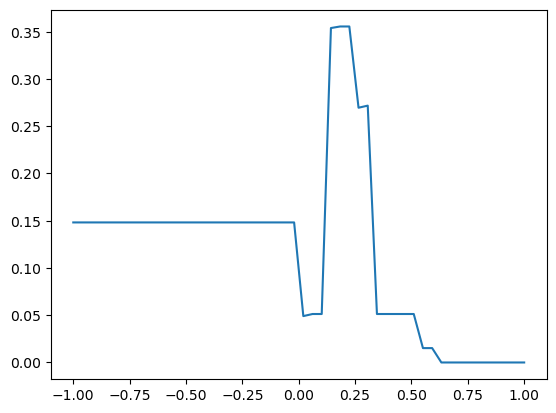

In [4]:
#LE
import numpy as np
import matplotlib.pyplot as plt

 
def rbf(dist, t = 1.0):          #用热内核的方式选择权重
    '''
    rbf kernel function
    '''
    return np.exp(-(dist/t))

def cal_pairwise_dist(x):        #求欧式距离

    '''计算pairwise 距离, x是matrix
    (a-b)^2 = a^2 + b^2 - 2*a*b
    '''
    sum_x = np.sum(np.square(x), 1)    #每行求和
    dist = np.add(np.add(-2 * np.dot(x, x.T), sum_x).T, sum_x)
    #返回任意两个点之间距离的平方
    return dist

def cal_rbf_dist(data, n_neighbors = 50, t = 1):

    dist = cal_pairwise_dist(data)
    dist[dist < 0] = 0
    n = dist.shape[0]    #节点的个数
    rbf_dist = rbf(dist, t)    #赋权

    W = np.zeros((n, n))
    for i in range(n):
        index_ = np.argsort(dist[i])[1:1+n_neighbors]   #它返回按照升序排列的数组元素的索引值
        W[i, index_] = rbf_dist[i, index_]
        #W[index_, i] = rbf_dist[index_, i]

    return W

def le(data,
          n_dims = 100,
          n_neighbors = 50, t = 1.0):
    '''

    :param data: (n_samples, n_features)
    :param n_dims: target dim
    :param n_neighbors: k nearest neighbors
    :param t: a param for rbf
    :return:
    '''
    N = data.shape[0]  #顶点的个数
    W = cal_rbf_dist(data, n_neighbors, t)    #权重矩阵
    D = np.zeros_like(W)   #创建和W形状相同的全0数组
    for i in range(N):
        D[i,i] = np.sum(W[i])

    D_inv = np.linalg.inv(D)
    L = D - W
    eig_val, eig_vec = np.linalg.eig(np.dot(D_inv, L))

    sort_index_ = np.argsort(eig_val)

    eig_val = eig_val[sort_index_]
    #print("eig_val[:10]: ", eig_val[:10])     #前十个特征值

    j = 0 
    while eig_val[j] < 1e-6:    #最小的特征值接近为0
        j+=1

    #print("j: ", j)

    sort_index_ = sort_index_[j:j+n_dims]
    eig_val_picked = eig_val[j:j+n_dims]
    #print(eig_val_picked)    #前十个特征值
    eig_vec_picked = eig_vec[:, sort_index_]   #前十个特征值对应的特征向量

    # print("L: ")
    # print(np.dot(np.dot(eig_vec_picked.T, L), eig_vec_picked))
    # print("D: ")
    # D not equal I ???
    #print(np.dot(np.dot(eig_vec_picked.T, D), eig_vec_picked))

    X_ndim = eig_vec_picked
    return X_ndim

if __name__ == '__main__':
    import pandas as pd

    #X=pd.read_csv(r"E:\jupyter notebook program\matrix_Friendship.csv",header=None)
    #X=pd.read_csv(r"E:\jupyter notebook program\matrix_celegans_n306.csv",header=None)
    #X=pd.read_csv(r"E:\jupyter notebook program\matrix_convote.csv",header=None)
    #X=pd.read_csv(r"E:\jupyter notebook program\matrix_moreno_innovation.csv",header=None)
    #X=pd.read_csv(r"E:\jupyter notebook program\matrix_foodweb.csv",header=None)
    X=pd.read_csv(r"E:\jupyter notebook program\matrix_wiki_talk.csv",header=None)
    X=X.values
    dist = cal_pairwise_dist(X)
    max_dist = np.max(dist)
    #print("max_dist", max_dist)
    X_ndim = le(X, n_neighbors = 30, t = max_dist*0.1)
#print(X_ndim)

ne=X_ndim

import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import spatial


#计算模块度的函数
def Modularity(array,cluster):  #有向网络的模块度
    #总边数
    m = np.sum(array) #对整个01矩阵求和，是有向网络中的总边数
    k1 = np.sum(array,axis=1) #axis指第二个维度，对第二个维度进行求和   求行和，每个节点的出度，返回一维数组
    k2 = np.sum(array,axis=0) #axis指第一个维度，对第一个维度进行求和   求列和，每个节点的入度，返回一维数组
    k2 = k2.reshape(k2.shape[0],1)
    #节点度数的乘积
    k1k2 = (k1*k2).T
    #任意两点连接边数的期望值
    Eij = k1k2/m
    #节点v和w的实际边数与随机网络下边数期望之差
    B = array - Eij
    #获取节点、社区矩阵
    node_cluster = np.dot(cluster,np.transpose(cluster))  #将cluster矩阵转置
    results = np.dot(B,node_cluster)
    #求和
    sum_results = np.trace(results) #这里求迹是因为上一步原矩阵与社区矩阵相乘之后，所求的即迹
    #模块度计算
    Q = sum_results / m
    return Q

#获得社区矩阵的函数，就是将pi中的社区划分改为矩阵形式，矩阵的行为点的数量，列为社区的数量      点的数量×社区的数量
def Get_cluster(G,pi):
    cluster=np.zeros((len(G),len(pi)),dtype='int32') # 'int32'数组中的每个元素是32位的整数
    #len(G)图中节点的数量，即图的大小
    #cluster是节点数×社区数的全整数0矩阵*
    s=0
    for i in pi:           #每个社区                              
        #j为点的标号
        for j in list(i):                     
            #将同一个社区的点对应位置赋值为1
            cluster[j][s]=1
        #一个社区赋值完成，进行下一个社区，直到全部赋值完成
        s=s+1
    return cluster

#计算D矩阵的函数
def calculateD(G_array,pi):
    matrixD=np.zeros((len(pi),len(pi)))   #社区的个数×社区的个数
    #遍历每两个不同社区，将所有的边数求和
    li1=[]
    s=0
    #这样取循环是为了保证两个社区是不同的
    for i in pi[s:]:
        for j in pi[s+1:]:
            if len(j)==0: #社区内没有节点
                break
            else:
                #对社区间的边数求和  使用有向网络邻接矩阵改成的无向网络的邻接矩阵 计算社区之间的边数                                               
                li1.append(np.sum(G_array[list(i),:][:,list(j)])/(len(i)+len(j)))
                #出的边和入的边算两遍
                #li1.append((np.sum(G_array[list(i),:][:,list(j)])+np.sum(G_array[list(j),:][:,list(i)]))/(len(i)+len(j)))
                #D=calculateD(G_array,pi1)
        s=s+1
        
    v=0
    for a in range(matrixD.shape[0]):
        for b in range(matrixD.shape[1]):
            if b>a:
                matrixD[a][b]=li1[v]
                #matrixD[b][a] = matrixD[a][b]
                v=v+1
    matrixD += matrixD.T
    #这里相当于改进，没有计算相同社区的
    '''
    #遍历相同的社区，将所有的边数求和
    b=0
    for x in pi:
          c=np.sum(G_array[list(x),:][:,list(x)])
          matrixD[b][b]=c
          b=b+1   
    '''
    #print("D矩阵为：",matrixD)
    return matrixD

#定位并合并两个社区，更新原列表pi
def Index_and_merge_communities(D,pi):                                               #×  看不懂
    #把D转换为一维的列表
    Dlist=D.reshape(1,D.size).tolist()[0]    #size返回数组中的元素总数 tolist将数组转换为python列表 
    M=Dlist.index(max(Dlist))  #这里也是不同的原因之一  #返回第一次出现max(Dlist)的索引
    s=divmod(M,len(pi))  #求M与len(pi)的商和余数，商和余数各代表一个社区
    jihe=pi[s[0]]|pi[s[1]]  #联合操作                                             #×
    if s[0]>s[1]: 
        del pi[s[0]]    #删除
        del pi[s[1]]
    elif s[0]==s[1]:
        del pi[s[0]]
    elif s[0]<s[1]:
        del pi[s[1]]
        del pi[s[0]]
    pi.append(jihe)
    return pi



x=[]
y=[]
z=[]
w=[]
for yu in np.linspace(-1,1,50):
    
    #计算程序运行时间
    import time
    start=time.time()

    Theta=yu
    #s=np.array(pd.read_csv(r"D:\数据及程序\dolphin1.csv"))  #阈值取110
    # 加载网络数据
    s=np.array(X)
    #生成一个无向图
    G=nx.DiGraph(s)  #原图
    #将读入的0-1矩阵赋值给G_array
    G_array=s
    g=nx.DiGraph(s)
    pi=[]   #社区
    Cr=[]   #单独的点



    #STEP1
    #取有连边的两个点
    for i in list(g.edges.data()):
        a=i[0]
        b=i[1]
        #用嵌入向量计算余弦相似度
        #scipy 模块中的spatial.distance.cosine() 函数可以用来计算余弦相似性，但是必须要用1减去函数值得到的才是余弦相似度
        Sab = 1 - spatial.distance.cosine(ne[a],ne[b])
        #将计算得到的节点相似度赋权给每一条边
        g.add_weighted_edges_from([(a,b,Sab)])
        #根据设置的阈值Theta，节点相似度小于阈值的则进行删边
        if Sab>Theta:
            pass    #空语句，什么也不做
        else:
            g.remove_edge(a,b)



    #找到网络中的连通分支，并将其添加到不同的列表    # nx.strongly_connected_components(G)   获取有向图的连通分量 
    for j in list(nx.strongly_connected_components(g)):  #获取无向图的连通分量
        if len(j)>1:
            pi.append(j)
        else:
            Cr.append(j)

    s_nondi=s        
    for i in range(len(s_nondi[0])):
        for j in range(len(s_nondi[0])):
            if s_nondi[i][j]==1:
                s_nondi[j][i]=1        
    G_nondi=nx.DiGraph(s_nondi)        

    #将Cr里面的单个点与pi中的连通分支做计算求得最大的F值，进行定位后，划分到pi中的社区
    #这里的定位是一个易错点
    #判断是否需要进行合并操作       
    if len(Cr)>0 and len(pi)>0:
        #遍历Cr中的单个点
        for i in Cr:
            #存储计算的Fc值的列表，并利用其进行定位
            elist=[]
            #遍历pi中的小社区
            for j in pi:   
                #计算每个点与小社区的Fc值
                Fc=(len(set(G_nondi.adj[list(i)[0]])&j))/len(j)   #G.adj获取邻接字典               
                elist.append(Fc)
            #找最大值可能是造成不同的原因，当同时有多个最大值时，python中提取的是第一个
            #利用列表的定位函数，将该点与有最大F值的社区合并
            M=elist.index(max(elist))  
            pi[M].add(list(i)[0])        




    pi1=pi.copy()      #pi1获取到pi的值
    Q2=0
    Q=Modularity(G_array, Get_cluster(G, pi))
    #当剩余社区数量大于2时，继续该循环
    while len(pi1)>2:
        #计算D矩阵
        D=calculateD(s_nondi,pi1)
        #合并指定的两个社区
        pi1=Index_and_merge_communities(D,pi1)
        #计算当前社区划分的模块度
        Q1=Modularity(G_array, Get_cluster(G, pi1))
        if Q1==Q2:    #模块度不变，取此次社区划分
            break
        if Q1>Q:     #模块度变大
            pi=pi1.copy()
            Q=Q1.copy()
        #当本次社区划分的模块度小于上一次时，结束本循环
        else:
            break
    
        Q2=Q1.copy()
    


    '''
    print("社区划分为：",pi)
    print("社区数量为：",len(pi))
    #模块度在0.3-0.7之间就可以称之为划分的很好
    #模块度的取值范围是[-0.5,1)
    print("模块度Q为：",Q)
    print("阈值为：",Theta)
    '''
    end=time.time()
    t=end-start
    #print("用时{:.10f}秒".format(t))    
    x.append(Theta)
    y.append(Q)
    z.append(len(pi))
    w.append(t)
plt.plot(x,y)
print('\t')
print('\t')
print('\t')
print("模块度最大为：",max(y))
print("阈值：",x[y.index(max(y))])
print("社区数量：",z[y.index(max(y))])
print("用时：",w[y.index(max(y))])

Please check the latest version manually on https://pypi.org/project/deepctr/#history


E:\Ana\lib\site-packages\tensorflow\python\keras\engine\training.py:1961: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
6/6 - 1s - loss: 0.6928
Epoch 2/50
6/6 - 0s - loss: 0.6903
Epoch 3/50
6/6 - 0s - loss: 0.6871
Epoch 4/50
6/6 - 0s - loss: 0.6827
Epoch 5/50
6/6 - 0s - loss: 0.6765
Epoch 6/50
6/6 - 0s - loss: 0.6671
Epoch 7/50
6/6 - 0s - loss: 0.6554
Epoch 8/50
6/6 - 0s - loss: 0.6401
Epoch 9/50
6/6 - 0s - loss: 0.6207
Epoch 10/50
6/6 - 0s - loss: 0.5979
Epoch 11/50
6/6 - 0s - loss: 0.5722
Epoch 12/50
6/6 - 0s - loss: 0.5428
Epoch 13/50
6/6 - 0s - loss: 0.5134
Epoch 14/50
6/6 - 0s - loss: 0.4813
Epoch 15/50
6/6 - 0s - loss: 0.4488
Epoch 16/50
6/6 - 0s - loss: 0.4184
Epoch 17/50
6/6 - 0s - loss: 0.3886
Epoch 18/50
6/6 - 0s - loss: 0.3624
Epoch 19/50
6/6 - 0s - loss: 0.3378
Epoch 20/50
6/6 - 0s - loss: 0.3152
Epoch 21/50
6/6 - 0s - loss: 0.2966
Epoch 22/50
6/6 - 0s - loss: 0.2802
Epoch 23/50
6/6 - 0s - loss: 0.2661
Epoch 24/50
6/6 - 0s - loss: 0.2545
Epoch 25/50
6/6 - 0s - loss: 0.2433
Epoch 26/50
6/6 - 0s - loss: 0.2355
Epoch 27/50
6/6 - 0s - loss: 0.2272
Epoch 28/50
6/6 - 0s - loss: 0.2233
E

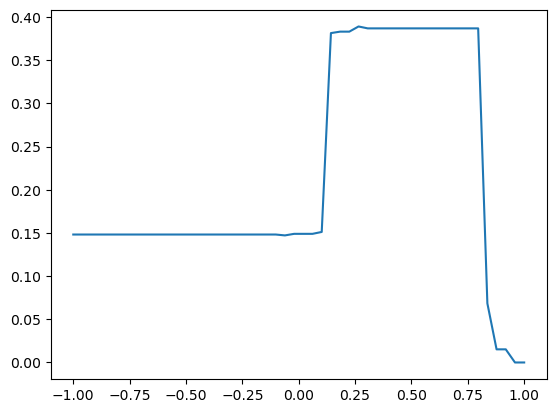

In [5]:
#LINE
from gensim.models import Word2Vec
import networkx as nx
import pandas as pd
import numpy as np
# 加载网络数据

#data=pd.read_csv(r"E:\jupyter notebook program\matrix_Friendship.csv",header=None)
#data=pd.read_csv(r"E:\jupyter notebook program\matrix_celegans_n306.csv",header=None)
#data=pd.read_csv(r"E:\jupyter notebook program\matrix_convote.csv",header=None)
#data=pd.read_csv(r"E:\jupyter notebook program\matrix_moreno_innovation.csv",header=None)
#data=pd.read_csv(r"E:\jupyter notebook program\matrix_foodweb.csv",header=None)
data=pd.read_csv(r"E:\jupyter notebook program\matrix_wiki_talk.csv",header=None)
#生成一个无向图
s=np.array(data)
G=nx.DiGraph(s)  #原图

# 定义随机游走策略
from ge.models import LINE
#使用 Python 中的 LINE 库来训练一个基于图的嵌入模型。
#具体来说，它使用 G 对象作为输入图形，并指定了嵌入向量的大小为 128，使用二阶接近度作为模型的训练方式
line = LINE(G, embedding_size=128, order='second')

# 训练模型
# batch_size 参数指定了批量大小，epochs 参数指定了训练轮数，verbose 参数指定了训练过程中的输出详细程度。
line.train(batch_size=1024, epochs=50, verbose=2)    # 训练 LINE 模型
embeddings = line.get_embeddings()   # 获取节点的嵌入向量

aline=[]                               # 创建一个空列表 a
for i in embeddings.values():      # 遍历嵌入向量字典的值
    aline.append(i)                   # 将嵌入向量添加到列表 a 中
aline                                  # 打印列表 a
ne=aline

import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import spatial


#计算模块度的函数
def Modularity(array,cluster):  #有向网络的模块度
    #总边数
    m = np.sum(array) #对整个01矩阵求和，是有向网络中的总边数
    k1 = np.sum(array,axis=1) #axis指第二个维度，对第二个维度进行求和   求行和，每个节点的出度，返回一维数组
    k2 = np.sum(array,axis=0) #axis指第一个维度，对第一个维度进行求和   求列和，每个节点的入度，返回一维数组
    k2 = k2.reshape(k2.shape[0],1)
    #节点度数的乘积
    k1k2 = (k1*k2).T
    #任意两点连接边数的期望值
    Eij = k1k2/m
    #节点v和w的实际边数与随机网络下边数期望之差
    B = array - Eij
    #获取节点、社区矩阵
    node_cluster = np.dot(cluster,np.transpose(cluster))  #将cluster矩阵转置
    results = np.dot(B,node_cluster)
    #求和
    sum_results = np.trace(results) #这里求迹是因为上一步原矩阵与社区矩阵相乘之后，所求的即迹
    #模块度计算
    Q = sum_results / m
    return Q

#获得社区矩阵的函数，就是将pi中的社区划分改为矩阵形式，矩阵的行为点的数量，列为社区的数量      点的数量×社区的数量
def Get_cluster(G,pi):
    cluster=np.zeros((len(G),len(pi)),dtype='int32') # 'int32'数组中的每个元素是32位的整数
    #len(G)图中节点的数量，即图的大小
    #cluster是节点数×社区数的全整数0矩阵*
    s=0
    for i in pi:           #每个社区                              
        #j为点的标号
        for j in list(i):                     
            #将同一个社区的点对应位置赋值为1
            cluster[j][s]=1
        #一个社区赋值完成，进行下一个社区，直到全部赋值完成
        s=s+1
    return cluster

#计算D矩阵的函数
def calculateD(G_array,pi):
    matrixD=np.zeros((len(pi),len(pi)))   #社区的个数×社区的个数
    #遍历每两个不同社区，将所有的边数求和
    li1=[]
    s=0
    #这样取循环是为了保证两个社区是不同的
    for i in pi[s:]:
        for j in pi[s+1:]:
            if len(j)==0: #社区内没有节点
                break
            else:
                #对社区间的边数求和  使用有向网络邻接矩阵改成的无向网络的邻接矩阵 计算社区之间的边数                                               
                li1.append(np.sum(G_array[list(i),:][:,list(j)])/(len(i)+len(j)))
                #出的边和入的边算两遍
                #li1.append((np.sum(G_array[list(i),:][:,list(j)])+np.sum(G_array[list(j),:][:,list(i)]))/(len(i)+len(j)))
                #D=calculateD(G_array,pi1)
        s=s+1
        
    v=0
    for a in range(matrixD.shape[0]):
        for b in range(matrixD.shape[1]):
            if b>a:
                matrixD[a][b]=li1[v]
                #matrixD[b][a] = matrixD[a][b]
                v=v+1
    matrixD += matrixD.T
    #这里相当于改进，没有计算相同社区的
    '''
    #遍历相同的社区，将所有的边数求和
    b=0
    for x in pi:
          c=np.sum(G_array[list(x),:][:,list(x)])
          matrixD[b][b]=c
          b=b+1   
    '''
    #print("D矩阵为：",matrixD)
    return matrixD

#定位并合并两个社区，更新原列表pi
def Index_and_merge_communities(D,pi):                                               #×  看不懂
    #把D转换为一维的列表
    Dlist=D.reshape(1,D.size).tolist()[0]    #size返回数组中的元素总数 tolist将数组转换为python列表 
    M=Dlist.index(max(Dlist))  #这里也是不同的原因之一  #返回第一次出现max(Dlist)的索引
    s=divmod(M,len(pi))  #求M与len(pi)的商和余数，商和余数各代表一个社区
    jihe=pi[s[0]]|pi[s[1]]  #联合操作                                             #×
    if s[0]>s[1]: 
        del pi[s[0]]    #删除
        del pi[s[1]]
    elif s[0]==s[1]:
        del pi[s[0]]
    elif s[0]<s[1]:
        del pi[s[1]]
        del pi[s[0]]
    pi.append(jihe)
    return pi



x=[]
y=[]
z=[]
w=[]
for yu in np.linspace(-1,1,50):
    
    #计算程序运行时间
    import time
    start=time.time()

    Theta=yu
    #s=np.array(pd.read_csv(r"D:\数据及程序\dolphin1.csv"))  #阈值取110
    # 加载网络数据
    s=np.array(data)
    #生成一个无向图
    G=nx.DiGraph(s)  #原图
    #将读入的0-1矩阵赋值给G_array
    G_array=s
    g=nx.DiGraph(s)
    pi=[]   #社区
    Cr=[]   #单独的点



    #STEP1
    #取有连边的两个点
    for i in list(g.edges.data()):
        a=i[0]
        b=i[1]
        #用嵌入向量计算余弦相似度
        #scipy 模块中的spatial.distance.cosine() 函数可以用来计算余弦相似性，但是必须要用1减去函数值得到的才是余弦相似度
        Sab = 1 - spatial.distance.cosine(ne[a],ne[b])
        #将计算得到的节点相似度赋权给每一条边
        g.add_weighted_edges_from([(a,b,Sab)])
        #根据设置的阈值Theta，节点相似度小于阈值的则进行删边
        if Sab>Theta:
            pass    #空语句，什么也不做
        else:
            g.remove_edge(a,b)



    #找到网络中的连通分支，并将其添加到不同的列表    # nx.strongly_connected_components(G)   获取有向图的连通分量 
    for j in list(nx.strongly_connected_components(g)):  #获取无向图的连通分量
        if len(j)>1:
            pi.append(j)
        else:
            Cr.append(j)

    s_nondi=s        
    for i in range(len(s_nondi[0])):
        for j in range(len(s_nondi[0])):
            if s_nondi[i][j]==1:
                s_nondi[j][i]=1        
    G_nondi=nx.DiGraph(s_nondi)        

    #将Cr里面的单个点与pi中的连通分支做计算求得最大的F值，进行定位后，划分到pi中的社区
    #这里的定位是一个易错点
    #判断是否需要进行合并操作       
    if len(Cr)>0 and len(pi)>0:
        #遍历Cr中的单个点
        for i in Cr:
            #存储计算的Fc值的列表，并利用其进行定位
            elist=[]
            #遍历pi中的小社区
            for j in pi:   
                #计算每个点与小社区的Fc值
                Fc=(len(set(G_nondi.adj[list(i)[0]])&j))/len(j)   #G.adj获取邻接字典               
                elist.append(Fc)
            #找最大值可能是造成不同的原因，当同时有多个最大值时，python中提取的是第一个
            #利用列表的定位函数，将该点与有最大F值的社区合并
            M=elist.index(max(elist))  
            pi[M].add(list(i)[0])        




    pi1=pi.copy()      #pi1获取到pi的值
    Q2=0
    Q=Modularity(G_array, Get_cluster(G, pi))
    #当剩余社区数量大于2时，继续该循环
    while len(pi1)>2:
        #计算D矩阵
        D=calculateD(s_nondi,pi1)
        #合并指定的两个社区
        pi1=Index_and_merge_communities(D,pi1)
        #计算当前社区划分的模块度
        Q1=Modularity(G_array, Get_cluster(G, pi1))
        if Q1==Q2:    #模块度不变，取此次社区划分
            break
        if Q1>Q:     #模块度变大
            pi=pi1.copy()
            Q=Q1.copy()
        #当本次社区划分的模块度小于上一次时，结束本循环
        else:
            break
    
        Q2=Q1.copy()
    


    '''
    print("社区划分为：",pi)
    print("社区数量为：",len(pi))
    #模块度在0.3-0.7之间就可以称之为划分的很好
    #模块度的取值范围是[-0.5,1)
    print("模块度Q为：",Q)
    print("阈值为：",Theta)
    '''
    end=time.time()
    t=end-start
    #print("用时{:.10f}秒".format(t))    
    x.append(Theta)
    y.append(Q)
    z.append(len(pi))
    w.append(t)
plt.plot(x,y)
print('\t')
print('\t')
print('\t')
print("模块度最大为：",max(y))
print("阈值：",x[y.index(max(y))])
print("社区数量：",z[y.index(max(y))])
print("用时：",w[y.index(max(y))])